In [1]:
import math

import re

import time

from google.colab import drive

In [2]:

try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [11]:
import pandas as pd

import numpy as np

import h5py

from gensim.models import Word2Vec

import gensim.models

from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Embedding

from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation

from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import SimpleRNN

from tensorflow.keras.layers import GRU

from tensorflow.keras.preprocessing.sequence import pad_sequences 

import re

from nltk.tokenize import word_tokenize

import nltk

nltk.download('punkt')

from nltk.corpus import stopwords 

nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
data_clickbait = pd . read_csv ('/content/gdrive/My Drive/SFResearch/Clickbait_Datasets/clickbait_data.txt' , sep = ' \ n ' , header = None )

data_noclickbait = pd . read_csv ('/content/gdrive/My Drive/SFResearch/Clickbait_Datasets/non_clickbait_data.txt' , sep = ' \ n ' , header = None )

data_clickbait = data_clickbait.sample(frac = 7.5/16)

data_noclickbait = data_noclickbait.sample(frac = 7.5/16)

data_clickbait['class'] = [1 for i in range(7500)]

data_noclickbait['class'] = [0 for i in range(7500)] 

data_Final = pd . concat (( data_clickbait , data_noclickbait ), ignore_index = True ) 

df = data_Final . rename ( columns = { 0 : "text" })

df = df . sample ( frac = 1 ). reset_index ( drop = True )

print (df.shape)

print (df.head(5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


(15000, 2)
                                                text  class
0  In Buffalo, Owens and Evans Are as Different a...      0
1  Here's Everything You Need To Know About "Star...      1
2     16 Exit Songs To Walkout Of Your Last Final To      1
3  Listen To This Incredible Isolated Vocal Of Da...      1
4            17 Reasons You Should Never Wear Makeup      1


In [7]:
df

,text,class
0,"Emergency declared in US state of Washington, ...",0
1,7 Reasons To Listen To BuzzFeed's New Podcast ...,1
2,20 Times Aidy Bryant Was Literally The Cutest ...,1
3,"We Know Which ""The Nightmare Before Christmas""...",1
4,African troops invade rebel-held island of Anj...,0
...,...,...
14995,U.S. military denies reports helicopter opened...,0
14996,Can You Name The Stuff In Our Solar System,1
14997,If Presidential Candidates Were Extinct Animals,1
14998,'Bloody Sunday Inquiry' publishes report into ...,0


In [111]:
stop_words  =  set ( stopwords . words ( 'english' ))

In [113]:
from sklearn.model_selection import train_test_split

L = []
for  i , token  in  enumerate ( df [ 'text' ]):
    token=token.replace('-', ' ')
    words = [ w for  w  in  token . split () ]
    L . append ( len ( words ))
sequence_size = max ( L )


#tokens=nltk.word_tokenize(token)
#print (tokens)

X = df['text']

y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [114]:
y_train = np.array(y_train)

y_test = np.array(y_test)

y_val = np.array(y_val)

In [18]:
WORD2VEC_VECTORS_BIN  =  "/content/gdrive/My Drive/SFResearch/Clickbait_Datasets/GoogleNews-vectors-negative300.bin.gz"

w2v  =  gensim . models . KeyedVectors . load_word2vec_format ( WORD2VEC_VECTORS_BIN , binary = True )

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [37]:
from keras.preprocessing.text import Tokenizer 

'''tokenizer = Tokenizer(num_words = sequence_size)

tokenizer.fit_on_texts(X_train)

sequences_1 = tokenizer.texts_to_sequences(X_train)

train_data = pad_sequences(sequences_1, maxlen = sequence_size , padding = 'post')

tokenizer.fit_on_texts(X_test)

sequences_2 = tokenizer.texts_to_sequences(X_test)

test_data = pad_sequences(sequences_2, maxlen = sequence_size , padding = 'post')

sequences_3 = tokenizer.texts_to_sequences(X_val)

val_data = pad_sequences(sequences_3, maxlen = sequence_size , padding = 'post')'''

train_data=np.zeros((len(X_train), sequence_size, 300))
val_data=np.zeros((len(X_val), sequence_size, 300))
test_data = np.zeros((len(X_test), sequence_size, 300))

for i,sentence in enumerate(X_train):
  sentence=sentence.replace('-', ' ')
  words=nltk.word_tokenize(sentence)
  try:
    j = 0
    for  w  in  words :
      train_data [ i , j ] = w2v [ w ]
      j+=1
  except:
    pass

for i,sentence in enumerate(X_val):
  sentence=sentence.replace('-',' ')
  words=nltk.word_tokenize(sentence)
  try:
    j = 0
    for  w  in  words :
      val_data [ i , j ] = w2v [ w ]
      j+=1
  except:
    pass

for i,sentence in enumerate(X_test):
  sentence=sentence.replace('-',' ')
  words=nltk.word_tokenize(sentence)
  try:
    j = 0
    for  w  in  words :
      test_data [ i , j ] = w2v [ w ]
      j+=1
  except:
    pass
  
print (test_data.shape)
print (train_data.shape)
print (val_data.shape)



(3000, 26, 300)
(9000, 26, 300)
(3000, 26, 300)


In [45]:
class PositionalEncoding(layers.Layer):
  
    def __init__(self) :

        super(PositionalEncoding, self).__init__()
    
    def get_angles(self, pos, i, d_model) :

        angles = 1 / np.power(10000., (2*(i//2)) / np.float32(d_model))

        return pos * angles

    def call(self, inputs) :

        seq_length = inputs.shape.as_list()[-2]

        d_model = inputs.shape.as_list()[-1]

        angles = self.get_angles(np.arange(seq_length)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)

        angles[:, 0::2] = np.sin(angles[:, 0::2])

        angles[:, 1::2] = np.cos(angles[:, 1::2])
        
        pos_encoding = angles[np.newaxis, ...]

        return inputs + tf.cast(pos_encoding, tf.float32)

In [100]:
def scaled_dot_product_attention(queries, keys, values, mask) :
  
    product = tf.matmul(queries, keys, transpose_b  = True)
    
    keys_dim = tf.cast(tf.shape(keys)[-1], tf.float32)

    scaled_product = product / tf.math.sqrt(keys_dim)
    
    #if mask is not None :

        #scaled_product += (mask * -1e9)

    attention = tf.matmul(tf.nn.softmax(scaled_product, axis = -1), values)
    
    return attention

In [95]:
class MultiHeadAttention(layers.Layer):
    
    def __init__(self, nb_proj) :

        super(MultiHeadAttention, self).__init__()

        self.nb_proj = nb_proj
        
    def build(self, input_shape) :

        self.d_model = input_shape[-1]

        assert self.d_model % self.nb_proj == 0
        
        self.d_proj = self.d_model // self.nb_proj
        
        self.query_lin = layers.Dense(units=self.d_model)

        self.key_lin = layers.Dense(units=self.d_model)

        self.value_lin = layers.Dense(units=self.d_model)
        
        self.final_lin = layers.Dense(units=self.d_model)
        
    def split_proj(self, inputs, batch_size): # inputs: (batch_size, seq_length, d_model)

        shape = (batch_size, sequence_size, self.nb_proj,self.d_proj)

        splited_inputs = tf.reshape(inputs, shape=shape) # (batch_size, seq_length, nb_proj, d_proj)

        return tf.transpose(splited_inputs, perm=[0, 2, 1, 3]) # (batch_size, nb_proj, seq_length, d_proj)
    
    def call(self, queries, keys, values, mask) :

        batch_size = tf.shape(queries)[0]
        
        queries = self.query_lin(queries)

        keys = self.key_lin(keys)

        values = self.value_lin(values)
        
        queries = self.split_proj(queries, batch_size)

        keys = self.split_proj(keys, batch_size)

        values = self.split_proj(values, batch_size)
        
        attention = scaled_dot_product_attention(queries, keys, values, mask)
        
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(attention,shape=(batch_size, -1, self.d_model))
        
        outputs = self.final_lin(concat_attention)
        
        return outputs

In [96]:
class EncoderLayer(layers.Layer):
    
    def __init__(self, FFN_units, nb_proj, dropout_rate) :

        super(EncoderLayer, self).__init__()

        self.FFN_units = FFN_units

        self.nb_proj = nb_proj

        self.dropout_rate = dropout_rate
    
    def build(self, input_shape) :

        self.d_model = input_shape[-1]
        
        self.multi_head_attention = MultiHeadAttention(self.nb_proj)

        self.dropout_1 = layers.Dropout(rate=self.dropout_rate)

        self.norm_1 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dense_1 = layers.Dense(units=self.FFN_units, activation="relu")

        self.dense_2 = layers.Dense(units=self.d_model)

        self.dropout_2 = layers.Dropout(rate=self.dropout_rate)

        self.norm_2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs, mask, training) :

        attention = self.multi_head_attention(inputs,
                                              inputs,
                                              inputs,
                                              mask)
        
        attention = self.dropout_1(attention, training=training)

        attention = self.norm_1(attention + inputs)
        
        outputs = self.dense_1(attention)

        outputs = self.dense_2(outputs)

        outputs = self.dropout_2(outputs, training=training)
        
        outputs = self.norm_2(outputs + attention)
        
        return outputs

In [ ]:
import os

dir = '/content/drive/My Drive/Glove'

embed_index = dict()
f = open(os.path.join(dir, 'glove.6B.300d.txt'), encoding="utf8")

In [ ]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embed_index[word] = coefs
f.close()

In [ ]:
len(tokenizer.word_index) + 1

15108

In [ ]:
embed_matrix = np.zeros(( len(tokenizer.word_index) + 1, 300))

for word, i in tokenizer.word_index.items():
    if i <  len(tokenizer.word_index) + 1 :
        embed_vector = embed_index.get(word)
        if embed_vector is not None:
            embed_matrix[i] = embed_vector

In [97]:
class Encoder(layers.Layer) :
    
    def __init__(self,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 d_model,
                 name="encoder") :

        super(Encoder, self).__init__(name=name)

        self.nb_layers = nb_layers

        self.d_model = d_model
        
        #self.embedding = layers.Embedding(vocab_size, d_model , weights = [embed_matrix])

        self.pos_encoding = PositionalEncoding()

        self.dropout = layers.Dropout(rate=dropout_rate)

        self.enc_layers = [EncoderLayer(FFN_units,
                                        nb_proj,
                                        dropout_rate) 
                           for _ in range(nb_layers)]
    
    def call(self, inputs, mask, training) :

        #outputs = self.embedding(inputs)

        inputs *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        outputs = self.pos_encoding(inputs)

        outputs = self.dropout(outputs, training)
        
        for i in range(self.nb_layers) :
          
            outputs = self.enc_layers[i](outputs, mask, training)

        return outputs

In [98]:
class Transformer(tf.keras.Model):
    
    def __init__(self,
                 d_model,
                 nb_layers,
                 FFN_units,
                 nb_proj,
                 dropout_rate,
                 name="transformer"):
        super(Transformer, self).__init__(name=name)
        
        self.encoder = Encoder(nb_layers,
                               FFN_units,
                               nb_proj,
                               dropout_rate,
                               d_model)
        # self.last_linear = layers.Dense(units=vocab_size_dec, name="lin_ouput")
    
    def create_padding_mask(self, seq):
        mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
        mask=mask[:, tf.newaxis, :]
        return mask

    def create_look_ahead_mask(self, seq):
        seq_len = tf.shape(seq)[1]
        look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return look_ahead_mask
    
    def call(self, enc_inputs, training = True):
        enc_mask = self.create_padding_mask(enc_inputs)
        
        enc_outputs = self.encoder(enc_inputs, enc_mask, training)
        
        return enc_outputs

In [101]:
D_MODEL = 300

NB_LAYERS = 2

FFN_UNITS = 512

NB_PROJ = 4

DROPOUT_RATE = 0.1

transformer = Transformer(d_model = D_MODEL,
                          nb_layers = NB_LAYERS,
                          FFN_units = FFN_UNITS,
                          nb_proj = NB_PROJ,
                          dropout_rate = DROPOUT_RATE)


inputs = layers.Input(shape = (sequence_size,D_MODEL))

x = transformer(inputs)

x = layers.Flatten()(x)

x = layers.Dense(512, activation="relu")(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(256, activation="relu")(x)

x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 26, 300)]         0         
_________________________________________________________________
transformer (Transformer)    (None, 26, 300)           1340824   
_________________________________________________________________
flatten_4 (Flatten)          (None, 7800)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               3994112   
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0   

In [102]:
history = model.fit(train_data , y_train , batch_size = 64 , epochs = 20 , validation_data = (val_data , y_val), verbose = 1)

Epoch 1/20
141/141 [==============================] - 3s 21ms/step - loss: 0.4928 - accuracy: 0.8903 - val_loss: 0.1833 - val_accuracy: 0.9423
Epoch 2/20
141/141 [==============================] - 2s 17ms/step - loss: 0.1747 - accuracy: 0.9433 - val_loss: 0.1894 - val_accuracy: 0.9393
Epoch 3/20
141/141 [==============================] - 2s 17ms/step - loss: 0.1589 - accuracy: 0.9497 - val_loss: 0.1960 - val_accuracy: 0.9443
Epoch 4/20
141/141 [==============================] - 2s 17ms/step - loss: 0.1487 - accuracy: 0.9517 - val_loss: 0.1740 - val_accuracy: 0.9447
Epoch 5/20
141/141 [==============================] - 2s 17ms/step - loss: 0.1403 - accuracy: 0.9548 - val_loss: 0.1944 - val_accuracy: 0.9387
Epoch 6/20
141/141 [==============================] - 2s 17ms/step - loss: 0.1322 - accuracy: 0.9609 - val_loss: 0.1894 - val_accuracy: 0.9447
Epoch 7/20
141/141 [==============================] - 2s 18ms/step - loss: 0.1290 - accuracy: 0.9591 - val_loss: 0.1800 - val_accuracy: 0.9490

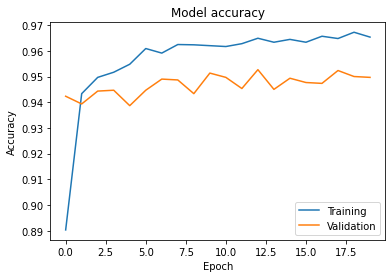

In [103]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

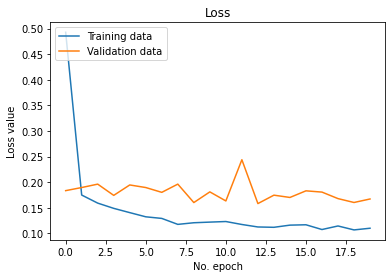

In [104]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [105]:
y_pred = model.predict(test_data)

In [106]:
y_pred

array([[0.9992131 ],
       [0.9996785 ],
       [0.9955011 ],
       ...,
       [0.00249756],
       [0.9982728 ],
       [0.9621674 ]], dtype=float32)

In [107]:
y_pred.shape

(3000, 1)

In [108]:
for i in range(y_pred.shape[0]) :

  if y_pred[i][0] >= 0.5 :

    y_pred[i][0] = 1

  else :

    y_pred[i][0] = 0

In [ ]:
y_pred = y_pred.astype('int64')

In [109]:
y_pred

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [84]:
y_test = y_test.reshape(-1,1)

AttributeError: ignored

In [110]:
metrics  =  classification_report (y_test , y_pred)

print ('Classification Report ')

print("\n")

print (metrics)

cm  =  confusion_matrix (y_test,y_pred)

print ('Confusion Matrix')

print("\n")

print (cm)

Classification Report 


              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1501
           1       0.93      0.97      0.95      1499

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000

Confusion Matrix


[[1393  108]
 [  46 1453]]
